In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import dbscan 
import plotly.express as px
from datetime import datetime

/Users/ivansvininnikov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
path = 'bank-full.csv'
original_df = pd.read_csv(path, sep=';')

In [3]:
df = original_df.copy()
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
# ## Input variables:

# ### bank client data:
#    1 - age (numeric)
#    2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student", "blue-collar","self-employed","retired","technician","services") 
#    3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
#    4 - education (categorical: "unknown","secondary","primary","tertiary")
#    5 - default: has credit in default? (binary: "yes","no")
#    6 - balance: average yearly balance, in euros (numeric) 
#    7 - housing: has housing loan? (binary: "yes","no")
#    8 - loan: has personal loan? (binary: "yes","no")

# ### related with the last contact of the current campaign:
#    9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
#   10 - day: last contact day of the month (numeric)
#   11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
#   12 - duration: last contact duration, in seconds (numeric)

# ### other attributes:
#   13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
#   14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
#   15 - previous: number of contacts performed before this campaign and for this client (numeric)
#   16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

# ## Output variable (desired target):
#   17 - y - has the client subscribed a term deposit? (binary: "yes","no")

In [5]:
df["month"] = df["month"].replace({'jan': 1,
                     'feb': 2,
                     'mar': 3,
                     'apr': 4,
                     'may': 5,
                     'jun': 6,
                     'jul': 7,
                     'aug': 8,
                     'sep': 9,
                     'oct': 10,
                     'nov': 11,
                     'dec': 12,
                    })

In [6]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,5,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,5,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,5,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,5,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,5,198,1,-1,0,unknown,no


In [7]:
num_columns = list(df.select_dtypes(include=['int','float']).columns)
cat_columns = list(df.select_dtypes(include=['object','bool','category']).columns)

print("Number of numerical columns:", len(num_columns))
print("Number of categorical columns:", len(cat_columns))
print("Total number of columns in the feature dataframe:", df.shape[1])

Number of numerical columns: 8
Number of categorical columns: 9
Total number of columns in the feature dataframe: 17


In [8]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values * 100
    summ['%missing'] = df.isnull().sum().values / len(df)
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [9]:
df_summary = pd.DataFrame(columns=['FEATURE', 'UNIQUE', 'UNIQUE_SHARE', 'ZEROS', 'ZEROS_SHARE', 'NAN', 'NAN_SHARE'])
df_summary

for column in df:
    df_summary = pd.concat([df_summary, pd.DataFrame({'FEATURE': column,
                                    'UNIQUE': df[column].nunique(),
                                    'UNIQUE_SHARE': round(df[column].nunique()/df.shape[0], 2),
                                    'ZEROS': df[column].isin([0]).sum(),
                                    'ZEROS_SHARE': round(df[column].isin([0]).sum()/df.shape[0], 2),
                                    'NAN': df[column].isna().sum(),
                                    'NAN_SHARE': round(df[column].isna().sum()/df.shape[0], 2)}, index=[0])], ignore_index=True)

In [10]:
df_summary

,FEATURE,UNIQUE,UNIQUE_SHARE,ZEROS,ZEROS_SHARE,NAN,NAN_SHARE
0,age,77,0.00,0,0.00,0,0.0
1,job,12,0.00,0,0.00,0,0.0
2,marital,3,0.00,0,0.00,0,0.0
3,education,4,0.00,0,0.00,0,0.0
4,default,2,0.00,0,0.00,0,0.0
5,balance,7168,0.16,3514,0.08,0,0.0
6,housing,2,0.00,0,0.00,0,0.0
7,loan,2,0.00,0,0.00,0,0.0
8,contact,3,0.00,0,0.00,0,0.0
9,day,31,0.00,0,0.00,0,0.0


In [11]:
summary(df[num_columns])

data shape: (45211, 8)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
age,int64,0,0.0,77,18.0,95.0,58,44,33
balance,int64,0,0.0,7168,-8019.0,102127.0,2143,29,2
day,int64,0,0.0,31,1.0,31.0,5,5,5
month,int64,0,0.0,12,1.0,12.0,5,5,5
duration,int64,0,0.0,1573,0.0,4918.0,261,151,76
campaign,int64,0,0.0,48,1.0,63.0,1,1,1
pdays,int64,0,0.0,559,-1.0,871.0,-1,-1,-1
previous,int64,0,0.0,41,0.0,275.0,0,0,0


In [12]:
df.describe()

,age,balance,day,month,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,6.144655,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,2.408034,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,5.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,6.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,8.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,12.000000,4918.000000,63.000000,871.000000,275.000000


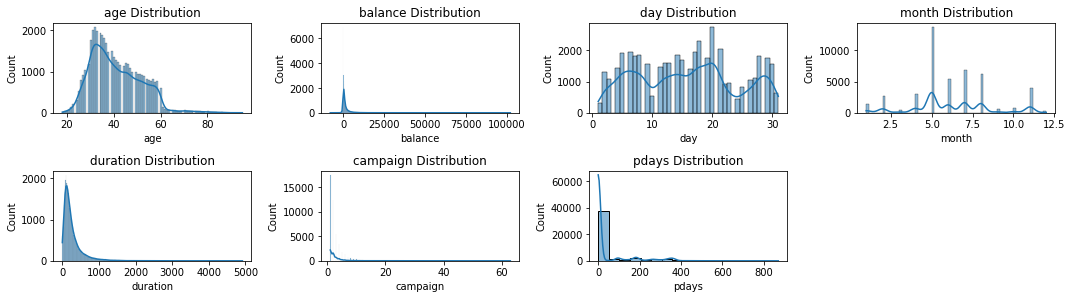

In [13]:
plt.figure(figsize=(15,10))
for id,column in enumerate(num_columns[:-1]):
    plt.subplot(5,4,id+1)
    sns.histplot(x=column,data=df, kde=True, palette="Set1")
    plt.title(f"{column} Distribution")
    plt.tight_layout()

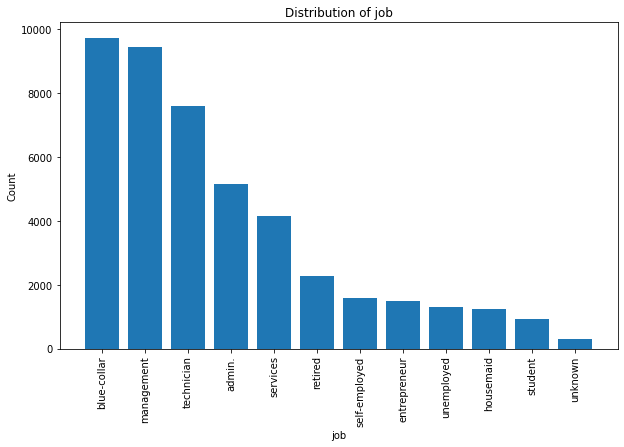

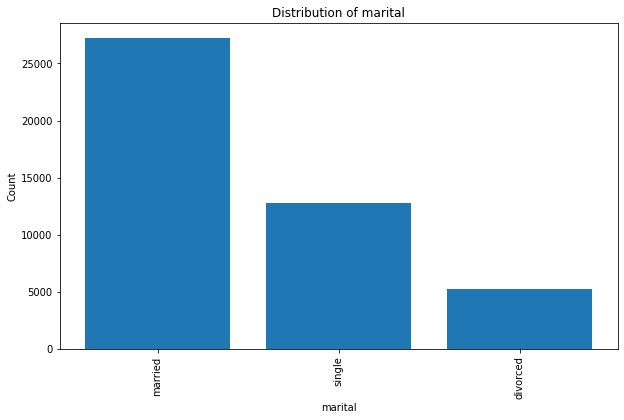

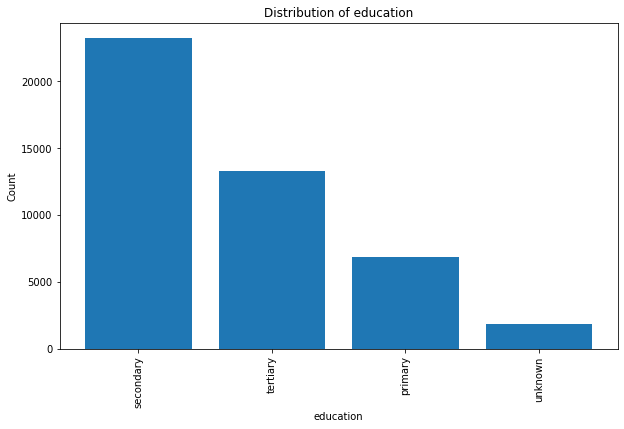

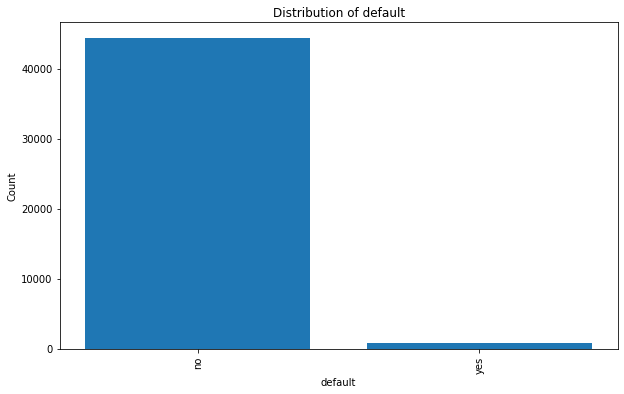

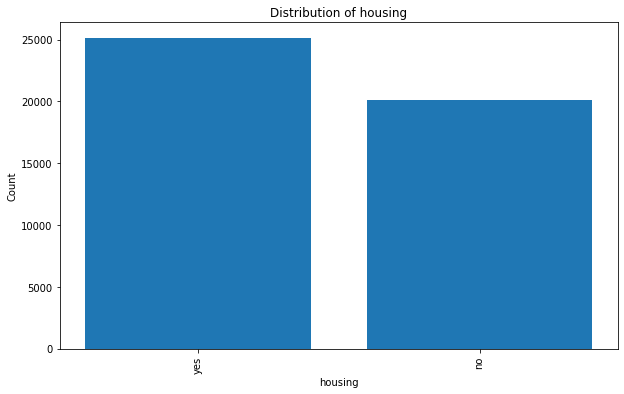

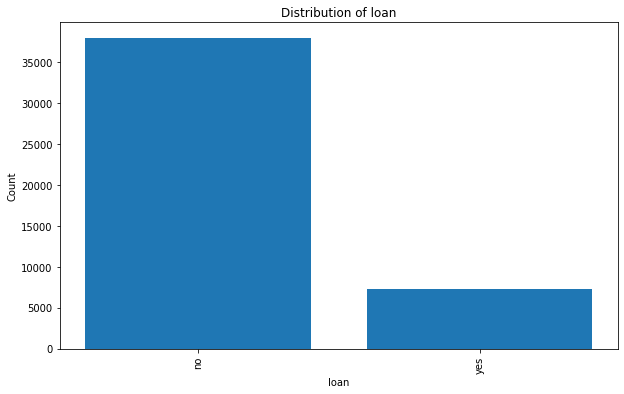

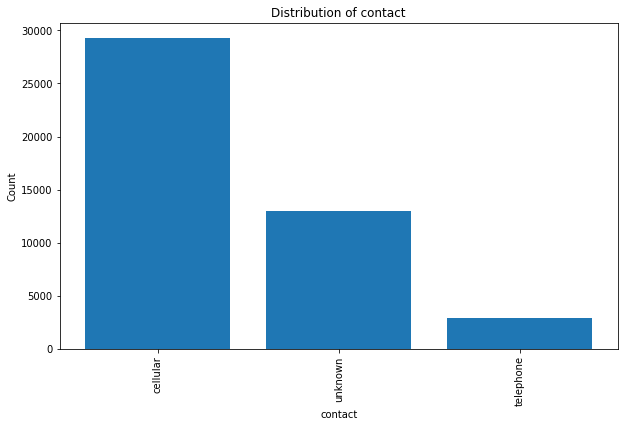

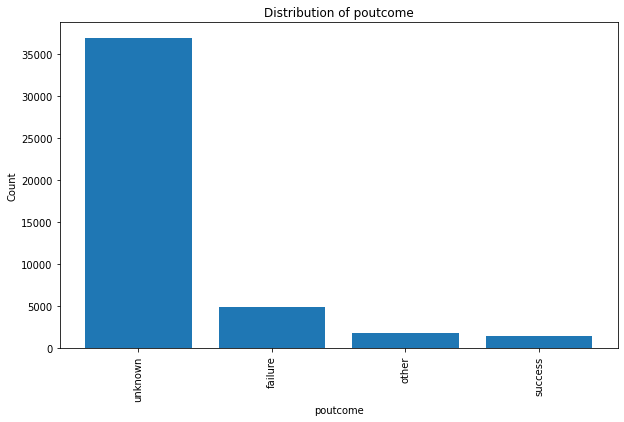

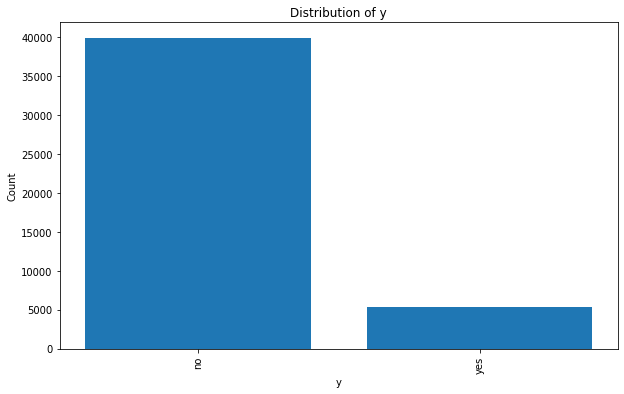

In [14]:
for column in cat_columns:
    value_counts = df[column].value_counts()
    plt.figure(figsize=(10, 6))
    plt.bar(value_counts.index, value_counts.values)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=90)
    plt.show()

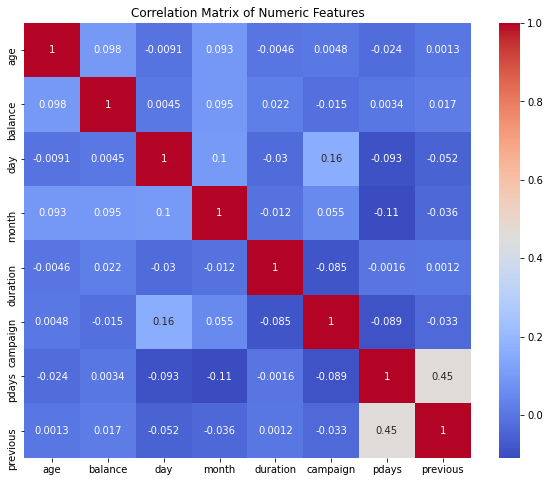

In [15]:
corr_matrix = df[num_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

## clear data 

In [16]:
# features default, housing, loan and y to binary
df['default'] = df['default'].map({'yes': 1, 'no': 0})
df['housing'] = df['housing'].map({'yes': 1, 'no': 0})
df['loan'] = df['loan'].map({'yes': 1, 'no': 0})
df['y'] = df['y'].map({'yes': 1, 'no': 0})

In [17]:
# one-hot encoding for categorical features
encoded_df = pd.get_dummies(df, columns=cat_columns)

In [18]:
def remove_outliers_iqr(data, column, threshold=1.5):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

In [19]:
# Remove outliers for each numeric column
for column in num_columns:
    encoded_df = remove_outliers_iqr(encoded_df, column)

In [20]:
encoded_df.head()

,age,balance,day,month,duration,campaign,pdays,previous,job_admin.,job_blue-collar,...,loan_1,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,y_0,y_1
0,58,2143,5,5,261,1,-1,0,0,0,...,0,0,0,1,0,0,0,1,1,0
1,44,29,5,5,151,1,-1,0,0,0,...,0,0,0,1,0,0,0,1,1,0
2,33,2,5,5,76,1,-1,0,0,0,...,1,0,0,1,0,0,0,1,1,0
3,47,1506,5,5,92,1,-1,0,0,1,...,0,0,0,1,0,0,0,1,1,0
4,33,1,5,5,198,1,-1,0,0,0,...,0,0,0,1,0,0,0,1,1,0


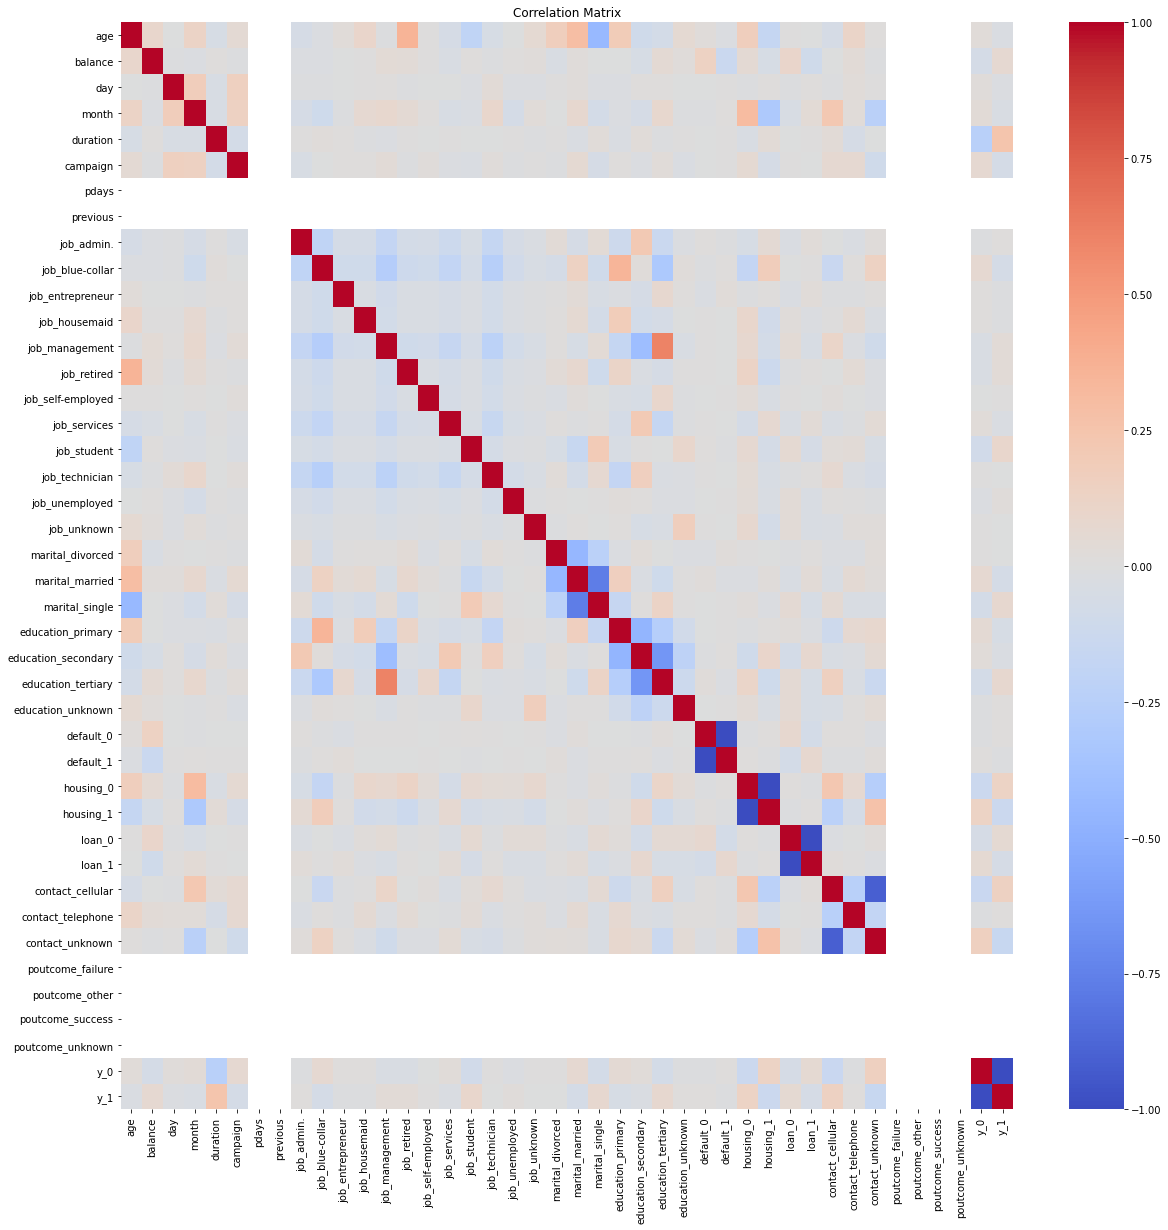

In [21]:
corr_matrix = encoded_df.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## K-Means 

In [22]:
from sklearn import preprocessing 

In [23]:
d = preprocessing.normalize(encoded_df)
encoded_df_norm = pd.DataFrame(d, columns = encoded_df.columns)
encoded_df.head()

,age,balance,day,month,duration,campaign,pdays,previous,job_admin.,job_blue-collar,...,loan_1,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,y_0,y_1
0,58,2143,5,5,261,1,-1,0,0,0,...,0,0,0,1,0,0,0,1,1,0
1,44,29,5,5,151,1,-1,0,0,0,...,0,0,0,1,0,0,0,1,1,0
2,33,2,5,5,76,1,-1,0,0,0,...,1,0,0,1,0,0,0,1,1,0
3,47,1506,5,5,92,1,-1,0,0,1,...,0,0,0,1,0,0,0,1,1,0
4,33,1,5,5,198,1,-1,0,0,0,...,0,0,0,1,0,0,0,1,1,0


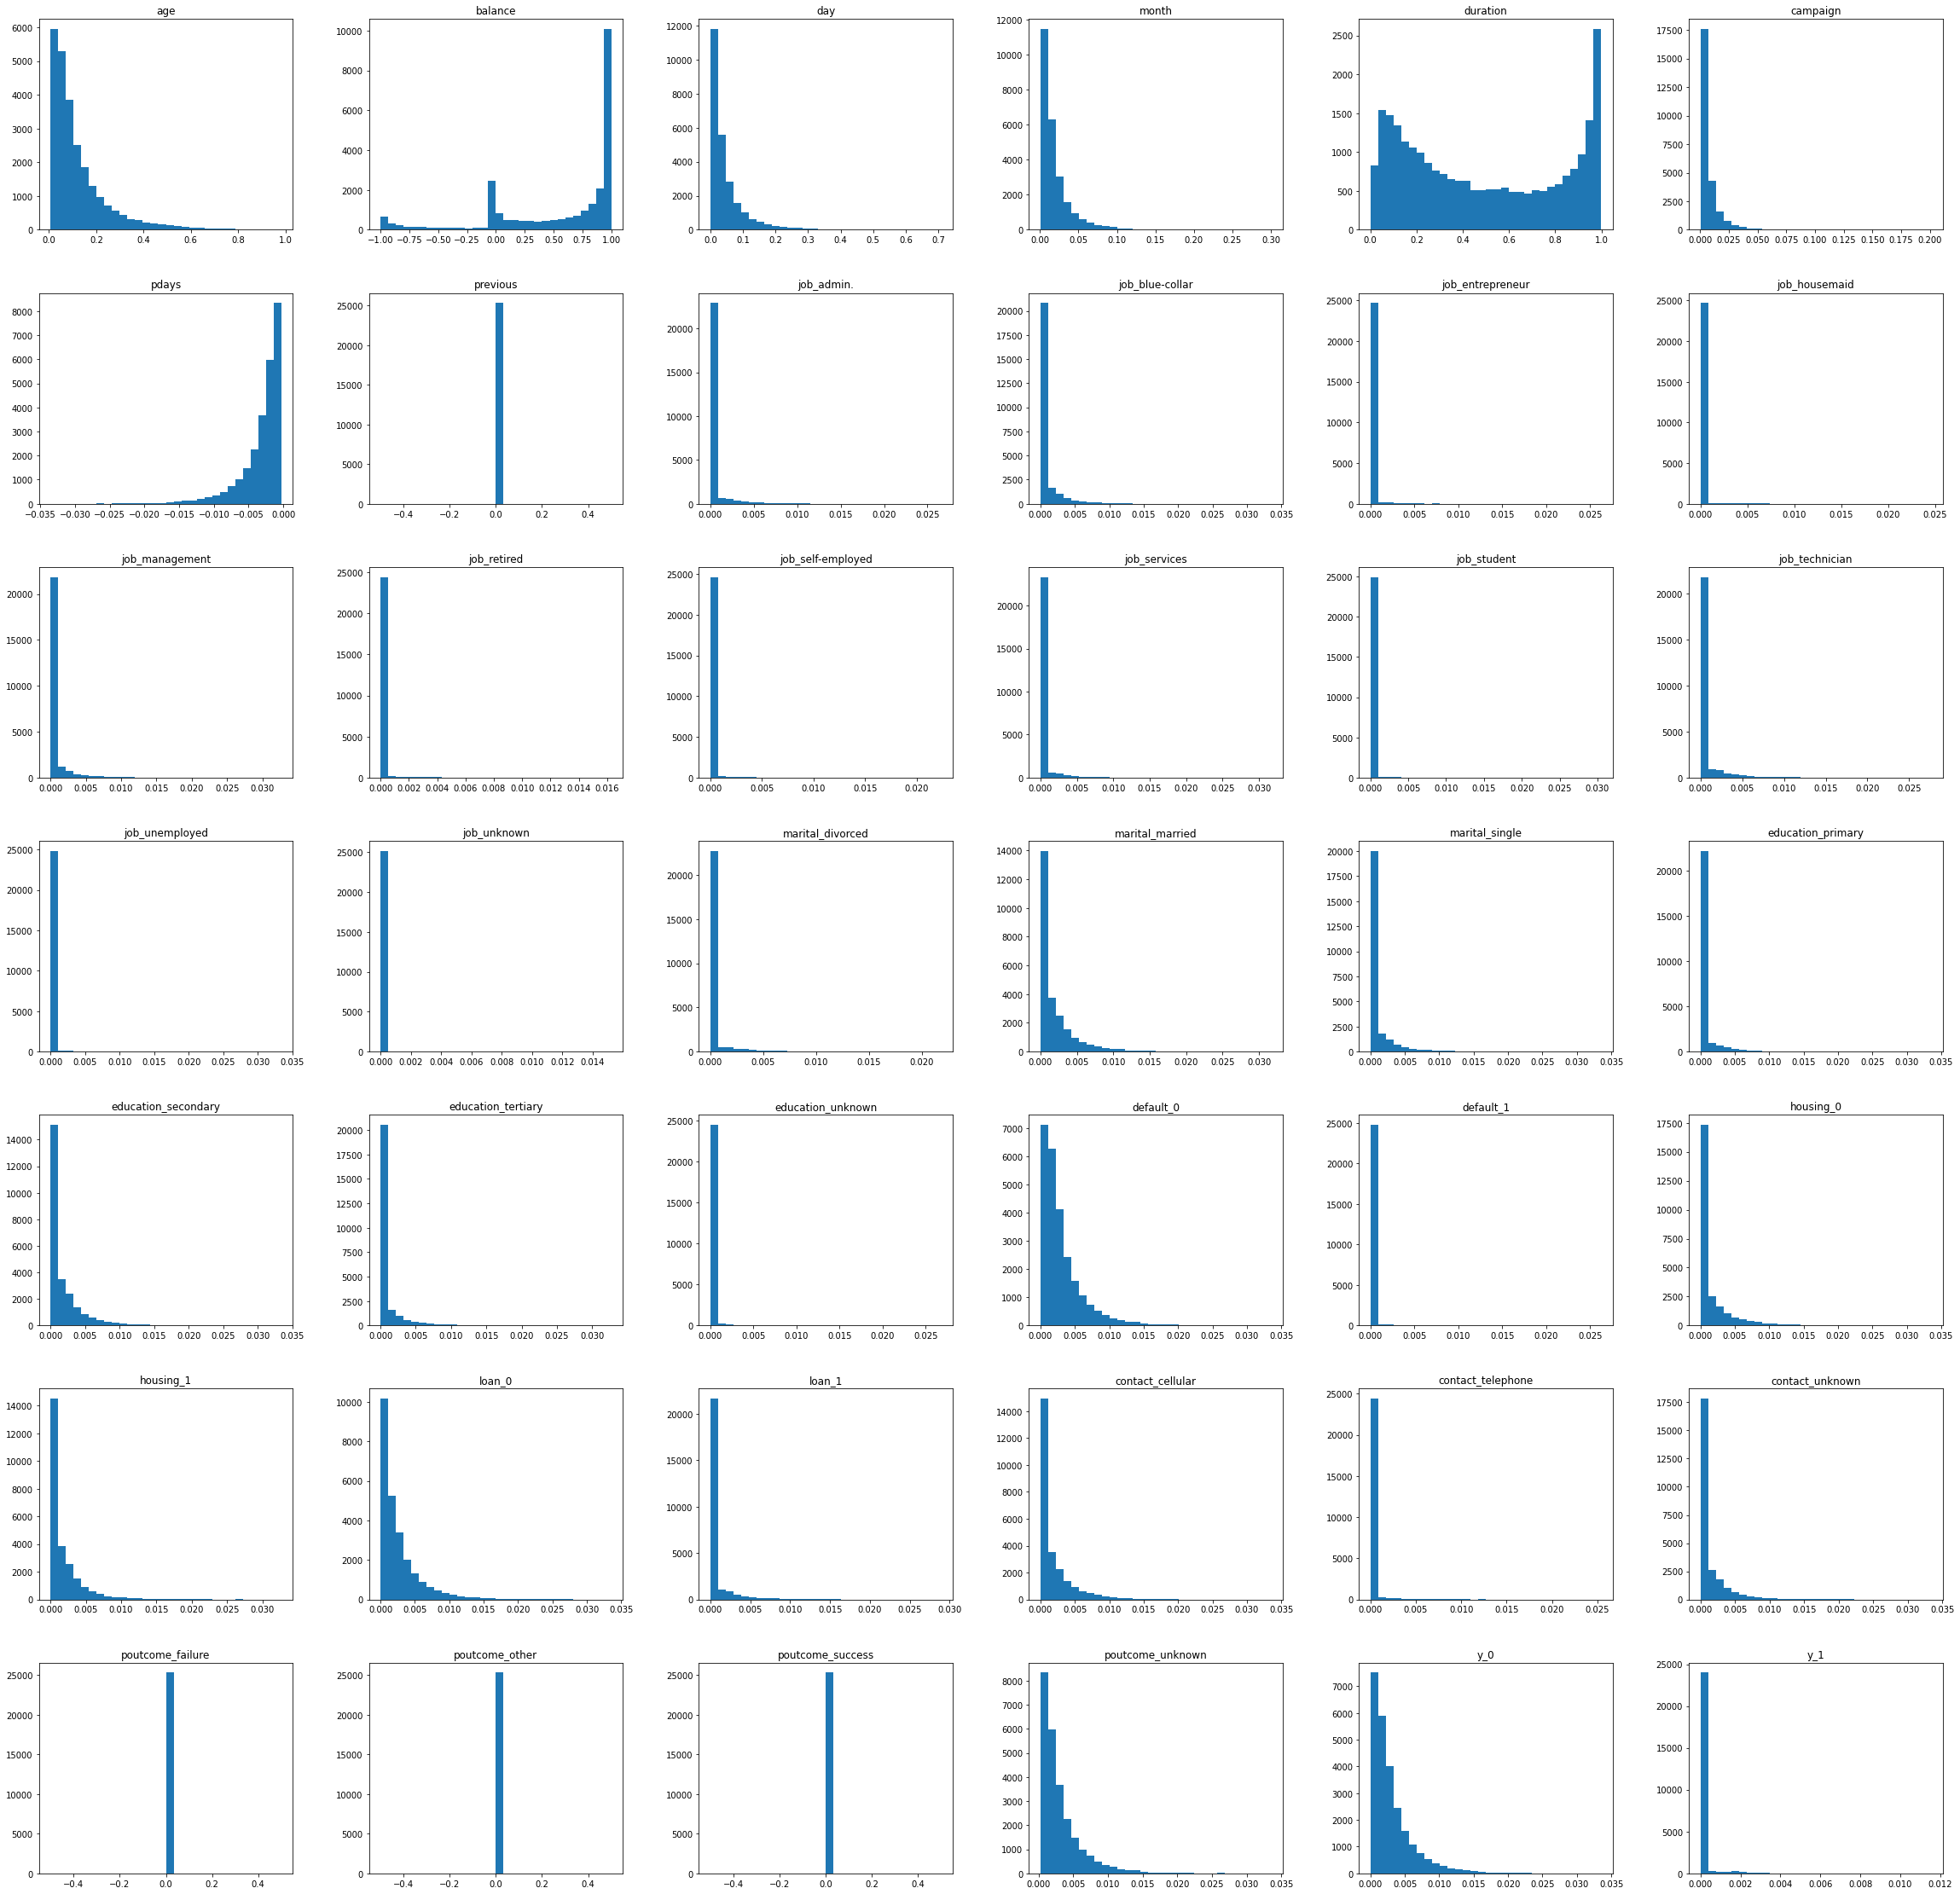

In [24]:
encoded_df_norm.hist(bins = 30, figsize = (40,40), grid = False)
plt.show()

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [26]:
encoded_df_norm.columns

Index(['age', 'balance', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_0', 'default_1', 'housing_0', 'housing_1',
       'loan_0', 'loan_1', 'contact_cellular', 'contact_telephone',
       'contact_unknown', 'poutcome_failure', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown', 'y_0', 'y_1'],
      dtype='object')

In [27]:
X = encoded_df_norm[['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_0', 'default_1', 'housing_0', 'housing_1',
       'loan_0', 'loan_1', 'contact_cellular', 'contact_telephone',
       'contact_unknown', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown', 'y_0', 'y_1']].copy()

In [28]:
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)

/Users/ivansvininnikov/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ivansvininnikov/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ivansvininnikov/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ivansvininnikov/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppre

In [29]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

/Users/ivansvininnikov/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ivansvininnikov/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ivansvininnikov/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ivansvininnikov/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppre

In [30]:
sns.set()

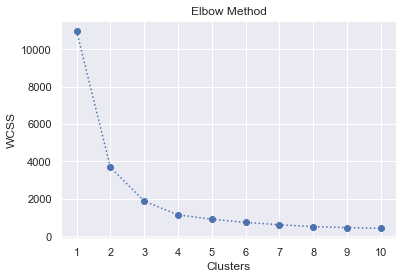

In [31]:
plt.plot(range(1, 11,), wcss, ':o')
plt.title('Elbow Method')
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.locator_params (axis='x', nbins= 11 )
plt.locator_params (axis='y', nbins= 11 )
plt.show()

In [32]:
X = encoded_df_norm.to_numpy()
X

array([[2.68564717e-02, 9.92300324e-01, 2.31521307e-03, ...,
        4.63042615e-04, 4.63042615e-04, 0.00000000e+00],
       [2.74790766e-01, 1.81112096e-01, 3.12262235e-02, ...,
        6.24524469e-03, 6.24524469e-03, 0.00000000e+00],
       [3.96412484e-01, 2.40249990e-02, 6.00624975e-02, ...,
        1.20124995e-02, 1.20124995e-02, 0.00000000e+00],
       ...,
       [4.53097319e-02, 9.71893749e-01, 2.94513257e-02, ...,
        1.13274330e-03, 0.00000000e+00, 1.13274330e-03],
       [9.19779256e-02, 0.00000000e+00, 5.28383828e-02, ...,
        1.95697714e-03, 0.00000000e+00, 1.95697714e-03],
       [4.08517306e-02, 9.97398857e-01, 2.15820464e-02, ...,
        7.70787370e-04, 7.70787370e-04, 0.00000000e+00]])

In [33]:
cluster_num = 4
k_means = KMeans(init = "k-means++", n_clusters = cluster_num, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[0 1 1 ... 0 1 0]


In [34]:
encoded_df_norm["cluster_names"] = labels
encoded_df_norm.head()

,age,balance,day,month,duration,campaign,pdays,previous,job_admin.,job_blue-collar,...,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,y_0,y_1,cluster_names
0,0.026856,0.992300,0.002315,0.002315,0.120854,0.000463,-0.000463,0.0,0.0,0.000000,...,0.0,0.0,0.000463,0.0,0.0,0.0,0.000463,0.000463,0.0,0
1,0.274791,0.181112,0.031226,0.031226,0.943032,0.006245,-0.006245,0.0,0.0,0.000000,...,0.0,0.0,0.006245,0.0,0.0,0.0,0.006245,0.006245,0.0,1
2,0.396412,0.024025,0.060062,0.060062,0.912950,0.012012,-0.012012,0.0,0.0,0.000000,...,0.0,0.0,0.012012,0.0,0.0,0.0,0.012012,0.012012,0.0,1
3,0.031135,0.997642,0.003312,0.003312,0.060945,0.000662,-0.000662,0.0,0.0,0.000662,...,0.0,0.0,0.000662,0.0,0.0,0.0,0.000662,0.000662,0.0,0
4,0.164273,0.004978,0.024890,0.024890,0.985636,0.004978,-0.004978,0.0,0.0,0.000000,...,0.0,0.0,0.004978,0.0,0.0,0.0,0.004978,0.004978,0.0,1


In [35]:
four_classes_table_mean = encoded_df_norm.groupby('cluster_names').mean()
four_classes_table_median = encoded_df_norm.groupby('cluster_names').median()
four_classes_table_mode = encoded_df_norm.groupby('cluster_names').agg(pd.Series.mode)
four_classes_table_mean

<ipython-input-35-c3a69ad4713c>:3: FutureWarning: ['balance', 'day', 'month', 'duration', 'campaign', 'pdays', 'poutcome_unknown'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  four_classes_table_mode = encoded_df_norm.groupby('cluster_names').agg(pd.Series.mode)


,age,balance,day,month,duration,campaign,pdays,previous,job_admin.,job_blue-collar,...,loan_1,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,y_0,y_1
cluster_names,,,,,,,,,,,,,,,,,,,,,
0,0.058179,0.971170,0.021751,0.008372,0.183166,0.003373,-0.001449,0.0,0.000165,0.000342,...,0.000226,0.000761,0.000086,0.000602,0.0,0.0,0.0,0.001449,0.001399,0.000050
1,0.235380,0.072781,0.091639,0.036371,0.923909,0.013668,-0.005925,0.0,0.000677,0.001274,...,0.001046,0.003436,0.000334,0.002155,0.0,0.0,0.0,0.005925,0.005760,0.000165
2,0.124010,-0.824500,0.052379,0.018509,0.458649,0.007064,-0.003181,0.0,0.000432,0.000951,...,0.000989,0.001500,0.000077,0.001604,0.0,0.0,0.0,0.003181,0.003157,0.000024
3,0.144666,0.700921,0.054655,0.021539,0.657897,0.008272,-0.003650,0.0,0.000430,0.000836,...,0.000632,0.002060,0.000154,0.001436,0.0,0.0,0.0,0.003650,0.003478,0.000172


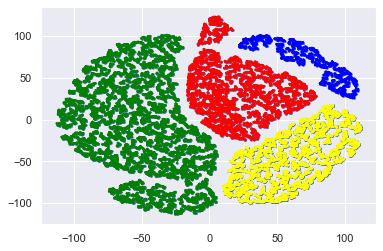

In [36]:
from sklearn.manifold import TSNE

tsne_df = TSNE(n_components=2, perplexity=20).fit_transform(encoded_df_norm)
encoded_df_norm["tsneX"] = tsne_df[:,0]
encoded_df_norm["tsneY"] = tsne_df[:,1]

plt.scatter(encoded_df_norm["tsneX"], encoded_df_norm["tsneY"],s=2,)

def colorer(row,column):
    if row[column] == 0:
        return "Green"
    if row[column] == 1:
        return "Red"
    if row[column] == 2:
        return "Blue"
    if row[column] == 3:
        return "Yellow"
    return "Orange"

encoded_df_norm["цвет"] = encoded_df_norm.apply(colorer,axis = 1,column = "cluster_names")
plt.scatter(encoded_df_norm["tsneX"], encoded_df_norm["tsneY"],s=2,c=list(encoded_df_norm['цвет']))
plt.show()

In [37]:
encoded_df_norm["cluster_names"].value_counts()

0    11779
1     6288
3     5329
2     1910
Name: cluster_names, dtype: int64

In [38]:
df["cluster_names"] = encoded_df_norm["cluster_names"]

In [40]:
df.describe()

,age,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,y,cluster_names
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,25306.000000
mean,40.936210,0.018027,1362.272058,0.555838,0.160226,15.806419,6.144655,258.163080,2.763841,40.197828,0.580323,0.116985,1.031178
std,10.618762,0.133049,3044.765829,0.496878,0.366820,8.322476,2.408034,257.527812,3.098021,100.128746,2.303441,0.321406,1.175734
min,18.000000,0.000000,-8019.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000
25%,33.000000,0.000000,72.000000,0.000000,0.000000,8.000000,5.000000,103.000000,1.000000,-1.000000,0.000000,0.000000,0.000000
50%,39.000000,0.000000,448.000000,1.000000,0.000000,16.000000,6.000000,180.000000,2.000000,-1.000000,0.000000,0.000000,1.000000
75%,48.000000,0.000000,1428.000000,1.000000,0.000000,21.000000,8.000000,319.000000,3.000000,-1.000000,0.000000,0.000000,2.000000
max,95.000000,1.000000,102127.000000,1.000000,1.000000,31.000000,12.000000,4918.000000,63.000000,871.000000,275.000000,1.000000,3.000000


In [41]:
df.groupby("cluster_names").median()

<ipython-input-41-2fe3c342f4de>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby("cluster_names").median()


,age,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,y
cluster_names,,,,,,,,,,,,
0.0,40.0,0.0,351.0,1.0,0.0,17.0,7.0,170.0,2.0,-1.0,0.0,0.0
1.0,41.0,0.0,348.0,1.0,0.0,17.0,6.0,172.0,2.0,-1.0,0.0,0.0
2.0,39.0,0.0,363.5,1.0,0.0,19.0,6.0,173.0,2.0,-1.0,0.0,0.0
3.0,40.0,0.0,340.0,1.0,0.0,17.0,7.0,170.0,2.0,-1.0,0.0,0.0
